Libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import shapiro
from scipy.stats import levene
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy.stats import ks_2samp

Load Data

In [2]:
TRAIN = pd.read_csv("OB_train.csv")
TEST = pd.read_csv("OB_test.csv")

print(TRAIN.head())
print()
print(TRAIN.dtypes)
print()
print(TRAIN.isna().sum())

   id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS           NObeyesdad  
0  0.976473

In [3]:
print(TRAIN['Gender'].unique())
print(TRAIN['family_history_with_overweight'].unique())
print(TRAIN['NObeyesdad'].unique())

['Male' 'Female']
['yes' 'no']
['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


Multinomial Logistic Regression

In [4]:
X = TRAIN[['Gender','Age','Height','Weight','family_history_with_overweight']]
y = TRAIN['NObeyesdad']  


categorical = ['Gender', 'family_history_with_overweight']
numerical = ['Age', 'Height', 'Weight']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical),
        ('num', StandardScaler(), numerical)
    ])

# Pipeline with multinomial logistic regression
MLRmodel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

# Cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=8555)


n_scores = cross_val_score(MLRmodel, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Mean Accuracy: 0.843 (0.006)


                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.93      0.91       505
      Normal_Weight       0.85      0.79      0.82       617
     Obesity_Type_I       0.80      0.85      0.82       582
    Obesity_Type_II       0.92      0.94      0.93       650
   Obesity_Type_III       0.99      1.00      0.99       809
 Overweight_Level_I       0.66      0.69      0.68       485
Overweight_Level_II       0.74      0.64      0.69       504

           accuracy                           0.85      4152
          macro avg       0.83      0.83      0.83      4152
       weighted avg       0.85      0.85      0.85      4152



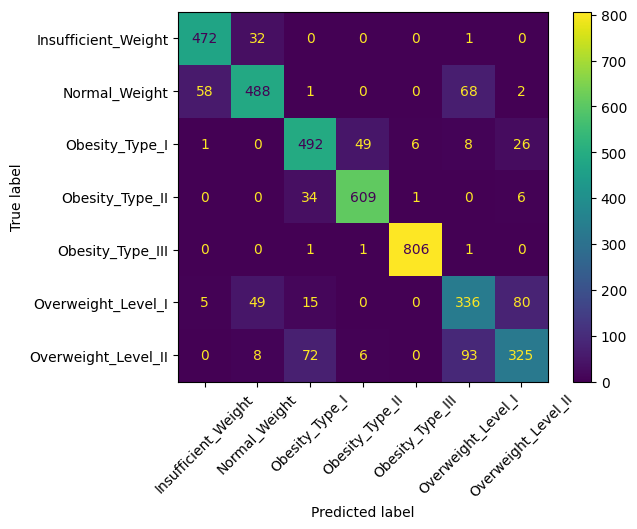

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8555)

# Fit model
MLRmodel.fit(X_train, y_train)

# Prediction on the test 
y_pred = MLRmodel.predict(X_test)

# Conf matrix
cm = confusion_matrix(y_test, y_pred, labels=MLRmodel.named_steps['classifier'].classes_)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=MLRmodel.named_steps['classifier'].classes_)
disp.plot(xticks_rotation=45)

print(classification_report(y_test, y_pred))



Applying to Test Data

In [6]:

X_final_test = TEST[['Gender','Age','Height','Weight','family_history_with_overweight']]
y_test_pred = MLRmodel.predict(X_final_test)


TEST['NObeyesdad'] = y_test_pred

first_col_name = TEST.columns[0]

output_df = TEST[[first_col_name, 'NObeyesdad']]

print(output_df.head())

# Save to CSV line commented out
#output_df.to_csv('MLR_predictions.csv', index=False)


      id          NObeyesdad
0  20758     Obesity_Type_II
1  20759  Overweight_Level_I
2  20760    Obesity_Type_III
3  20761     Obesity_Type_II
4  20762    Obesity_Type_III


Multinomial Logististic Regression Assumptions:

Response Variable is categorical: Passed. obesity level is categorical data

Linearity of logits: Plots below show there are some non-linear trends between logits and each category

Independent observations: Passed. 1.98 Durbin Watson stat indicates no autocorrelation.



In [8]:
#Linearity of logits
X_encoded = pd.get_dummies(X, drop_first=True)

X_encoded = X_encoded.astype(float)

X_with_const = sm.add_constant(X_encoded)


for category in y.unique():
    y_binary = (y == category).astype(int)
    
    X_with_const = sm.add_constant(X_encoded)
    
    model = sm.Logit(y_binary, X_with_const).fit(disp=False)
    
    log_odds = model.predict(X_with_const, linear=True)
    
    
    # for col in ['Age', 'Height', 'Weight']:
    #     plt.figure(figsize=(6, 4))
    #     sns.scatterplot(x=X[col], y=log_odds, alpha=0.5)
    #     plt.title(f'Logit vs {col} for class {category}')
    #     plt.xlabel(col)
    #     plt.ylabel('Logit')
    #     plt.show() #COMMENTED THIS OUT SO THAT THE 21 LOGIT PLOTS DON'T APPEAR. IF YOU WISH TO EVALUATE REMOVE THE HASHTAGS

#Independent Observations

X_encoded = pd.get_dummies(X, drop_first=True).astype(float)
X_with_const = sm.add_constant(X_encoded)

y_binary = (y == y.unique()[0]).astype(int)

# Fit model
model = sm.Logit(y_binary, X_with_const).fit()

# Get residuals 
residuals = y_binary - model.predict(X_with_const)

# Durbin-Watson 
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat:.3f}')



Optimization terminated successfully.
         Current function value: 0.326775
         Iterations 7
Durbin-Watson statistic: 1.989


C:\Users\jacob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
C:\Users\jacob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
C:\Users\jacob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
C:\Users\jacob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\

Linear Discriminant Analysis Model

In [9]:
X = TRAIN[['Gender','Age','Height','Weight','family_history_with_overweight']]
y = TRAIN['NObeyesdad']

categorical = ['Gender', 'family_history_with_overweight']
numerical = ['Age', 'Height', 'Weight']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical),
        ('num', StandardScaler(), numerical)
    ])

# Pipeline LDA
lda_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LDA())
])

# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=8555)

n_scores = cross_val_score(lda_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Mean Accuracy: 0.816 (0.006)


                     precision    recall  f1-score   support

Insufficient_Weight       0.82      0.92      0.87       505
      Normal_Weight       0.79      0.70      0.74       617
     Obesity_Type_I       0.82      0.81      0.81       582
    Obesity_Type_II       0.90      0.94      0.92       650
   Obesity_Type_III       0.99      0.99      0.99       809
 Overweight_Level_I       0.58      0.62      0.60       485
Overweight_Level_II       0.68      0.63      0.65       504

           accuracy                           0.82      4152
          macro avg       0.80      0.80      0.80      4152
       weighted avg       0.82      0.82      0.82      4152



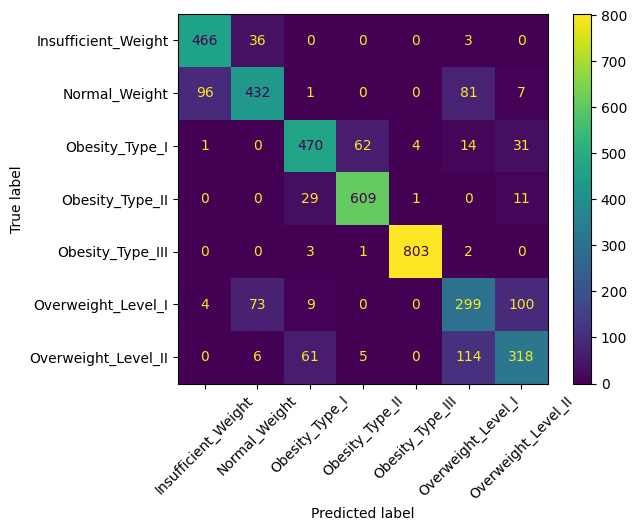

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8555)

# Fit model
lda_model.fit(X_train, y_train)

# Prediction on test
y_pred = lda_model.predict(X_test)

# Conf matrix
cm = confusion_matrix(y_test, y_pred, labels=lda_model.named_steps['classifier'].classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda_model.named_steps['classifier'].classes_)
disp.plot(xticks_rotation=45)

print(classification_report(y_test, y_pred))



Applying to Test Data

In [11]:

X_final_test = TEST[['Gender','Age','Height','Weight','family_history_with_overweight']]
y_test_pred = lda_model.predict(X_final_test)


TEST['NObeyesdad'] = y_test_pred


first_col_name = TEST.columns[0]


output_df = TEST[[first_col_name, 'NObeyesdad']]

print(output_df.head())

# Save to CSV line commented out
#output_df.to_csv('LDA_predictions.csv', index=False)

      id          NObeyesdad
0  20758     Obesity_Type_II
1  20759  Overweight_Level_I
2  20760    Obesity_Type_III
3  20761     Obesity_Type_II
4  20762    Obesity_Type_III


LDA Assumptions: 

Multivariate Normality: Failed. shapiro-wilk produces low p-values for each predictor vs each class.

Homogeneity of Varaince: Failed. Levene's test low pvalue suggest significant variance differences across classes

Linearity: Failed. Predictors vs discriminant functions show non-linear trends.

Independent observations: Passed.


Univariate normality for Age
Overweight_Level_II: p = 0.0000 (not normal)
Normal_Weight: p = 0.0000 (not normal)
Insufficient_Weight: p = 0.0000 (not normal)
Obesity_Type_III: p = 0.0000 (not normal)
Obesity_Type_II: p = 0.0000 (not normal)
Overweight_Level_I: p = 0.0000 (not normal)
Obesity_Type_I: p = 0.0000 (not normal)

Univariate normality for Height
Overweight_Level_II: p = 0.0000 (not normal)
Normal_Weight: p = 0.0000 (not normal)
Insufficient_Weight: p = 0.0000 (not normal)
Obesity_Type_III: p = 0.0000 (not normal)
Obesity_Type_II: p = 0.0000 (not normal)
Overweight_Level_I: p = 0.0000 (not normal)
Obesity_Type_I: p = 0.0000 (not normal)

Univariate normality for Weight
Overweight_Level_II: p = 0.0000 (not normal)
Normal_Weight: p = 0.0000 (not normal)
Insufficient_Weight: p = 0.0000 (not normal)
Obesity_Type_III: p = 0.0000 (not normal)
Obesity_Type_II: p = 0.0000 (not normal)
Overweight_Level_I: p = 0.0000 (not normal)
Obesity_Type_I: p = 0.0000 (not normal)
🔍 Levene’s Test 

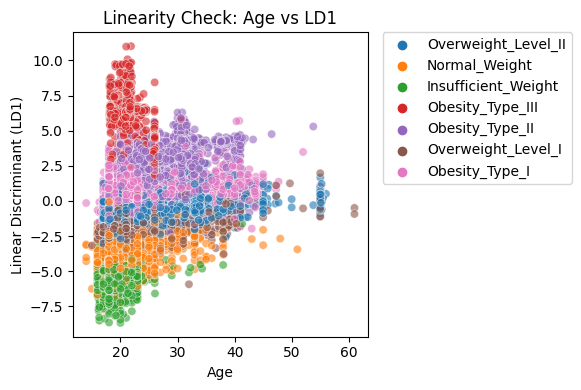

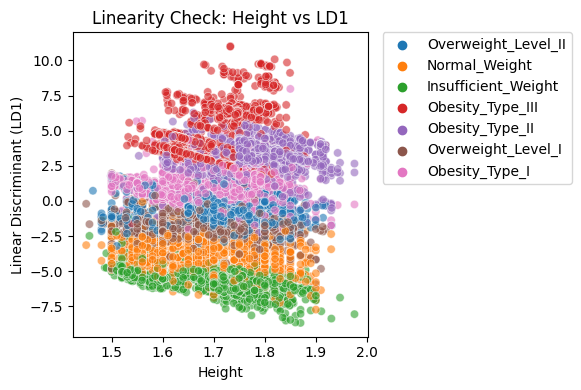

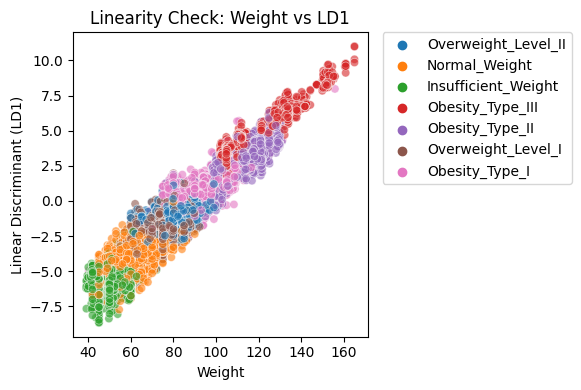

In [12]:
X_with_target = X.copy()
X_with_target['NObeyesdad'] = y

# Shapiro-Wilk test for each class and feature
for col in numerical:
    print(f"\nUnivariate normality for {col}")
    for cls in y.unique():
        values = X_with_target[X_with_target['NObeyesdad'] == cls][col]
        stat, p = shapiro(values)
        print(f"{cls}: p = {p:.4f} {'(normal)' if p > 0.05 else '(not normal)'}")

#Leven test
print("🔍 Levene’s Test for Homogeneity of Variance (per feature):\n")

for col in numerical:
    grouped_data = [X[y == cls][col].values for cls in y.unique()]
    
    stat, p = levene(*grouped_data)
    
    result = 'Equal variances' if p > 0.05 else 'Unequal variances'
    print(f"{col}: stat = {stat:.4f}, p = {p:.4f} → {result}")


#Linearity 
categorical = ['Gender', 'family_history_with_overweight']
numerical = ['Age', 'Height', 'Weight']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

X_processed = preprocessor.fit_transform(X)

lda = LinearDiscriminantAnalysis()
lda_scores = lda.fit_transform(X_processed, y)  

lda_df = pd.DataFrame(X[numerical].reset_index(drop=True))  
lda_df['LD1'] = lda_scores[:, 0]
lda_df['class'] = y.values

for col in numerical:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=lda_df, x=col, y='LD1', hue='class', alpha=0.6)
    plt.title(f'Linearity Check: {col} vs LD1')
    plt.xlabel(col)
    plt.ylabel('Linear Discriminant (LD1)')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()





Naive Bayes model

In [13]:

X = TRAIN[['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight']]
y = TRAIN['NObeyesdad']

categorical = ['Gender', 'family_history_with_overweight']
numerical = ['Age', 'Height', 'Weight']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical),
        ('num', StandardScaler(), numerical)
    ])

# Pipeline Gaussian Naive Bayes
nb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=8555)

n_scores = cross_val_score(nb_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Mean Accuracy: 0.629 (0.013)


                     precision    recall  f1-score   support

Insufficient_Weight       0.71      0.77      0.74       505
      Normal_Weight       0.54      0.38      0.44       617
     Obesity_Type_I       0.51      0.24      0.32       582
    Obesity_Type_II       0.68      0.98      0.80       650
   Obesity_Type_III       0.57      1.00      0.72       809
 Overweight_Level_I       0.29      0.10      0.15       485
Overweight_Level_II       0.54      0.40      0.46       504

           accuracy                           0.59      4152
          macro avg       0.55      0.55      0.52      4152
       weighted avg       0.55      0.59      0.54      4152



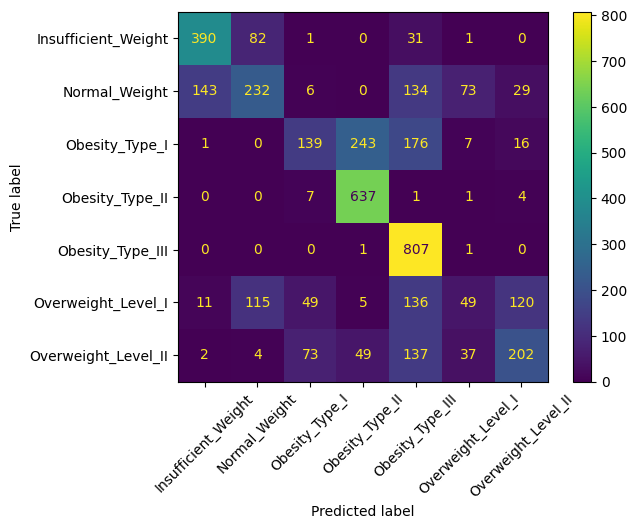

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8555)

# Fit model
nb_model.fit(X_train, y_train)

# Prediction on test
y_pred = nb_model.predict(X_test)

# Conf matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_model.named_steps['classifier'].classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.named_steps['classifier'].classes_)
disp.plot(xticks_rotation=45)

print(classification_report(y_test, y_pred))

Applying to Test Data

In [15]:

X_final_test = TEST[['Gender','Age','Height','Weight','family_history_with_overweight']]
y_test_pred = nb_model.predict(X_final_test)


TEST['NObeyesdad'] = y_test_pred

first_col_name = TEST.columns[0]

output_df = TEST[[first_col_name, 'NObeyesdad']]

print(output_df.head())

# Save to CSV line commented out
#output_df.to_csv('nb_predictions.csv', index=False)

      id        NObeyesdad
0  20758   Obesity_Type_II
1  20759  Obesity_Type_III
2  20760  Obesity_Type_III
3  20761    Obesity_Type_I
4  20762  Obesity_Type_III


NB Assumptions: 

Naivety Assumption "feature independence": Passed.  Correlation values for PREDICTORS exhibit weak correlations.

Class Conditional Independence: Failed. Knowing weight can help predict age or height even after knowing the class.



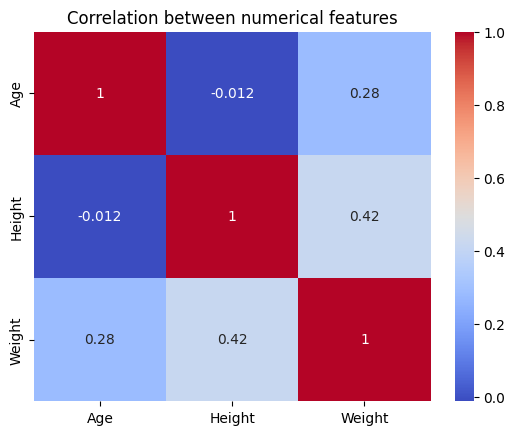

Class: Overweight_Level_II
             Age    Height    Weight
Age     1.000000 -0.006765  0.053189
Height -0.006765  1.000000  0.742823
Weight  0.053189  0.742823  1.000000 

Class: Normal_Weight
             Age    Height    Weight
Age     1.000000  0.026649  0.116521
Height  0.026649  1.000000  0.692550
Weight  0.116521  0.692550  1.000000 

Class: Insufficient_Weight
             Age    Height    Weight
Age     1.000000 -0.203022 -0.071283
Height -0.203022  1.000000  0.764557
Weight -0.071283  0.764557  1.000000 

Class: Obesity_Type_III
             Age    Height    Weight
Age     1.000000 -0.797912 -0.846333
Height -0.797912  1.000000  0.834752
Weight -0.846333  0.834752  1.000000 

Class: Obesity_Type_II
             Age    Height    Weight
Age     1.000000 -0.162905 -0.096004
Height -0.162905  1.000000  0.661455
Weight -0.096004  0.661455  1.000000 

Class: Overweight_Level_I
             Age    Height    Weight
Age     1.000000 -0.084464  0.037126
Height -0.084464  1.000000  

In [16]:
#Naivety assumption
# Numeric correlation matrix
numerical_data = TRAIN[numerical]
corr_matrix = numerical_data.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between numerical features')
plt.show()

#Class conditional independence 
for label in y.unique():
    subset = TRAIN[TRAIN['NObeyesdad'] == label]
    corr = subset[numerical].corr()
    print(f"Class: {label}")
    print(corr, "\n")




SVM 

In [17]:

X = TRAIN[['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight']]
y = TRAIN['NObeyesdad']

categorical = ['Gender', 'family_history_with_overweight']
numerical = ['Age', 'Height', 'Weight']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical),
        ('num', StandardScaler(), numerical)
    ])

# Pipeline with SVM 
svm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', decision_function_shape='ovr'))
])

# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=8555)

n_scores = cross_val_score(svm_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Mean Accuracy: 0.850 (0.006)


                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.94      0.91       505
      Normal_Weight       0.85      0.79      0.82       617
     Obesity_Type_I       0.81      0.84      0.83       582
    Obesity_Type_II       0.92      0.94      0.93       650
   Obesity_Type_III       0.99      1.00      0.99       809
 Overweight_Level_I       0.67      0.72      0.70       485
Overweight_Level_II       0.76      0.66      0.71       504

           accuracy                           0.85      4152
          macro avg       0.84      0.84      0.84      4152
       weighted avg       0.85      0.85      0.85      4152



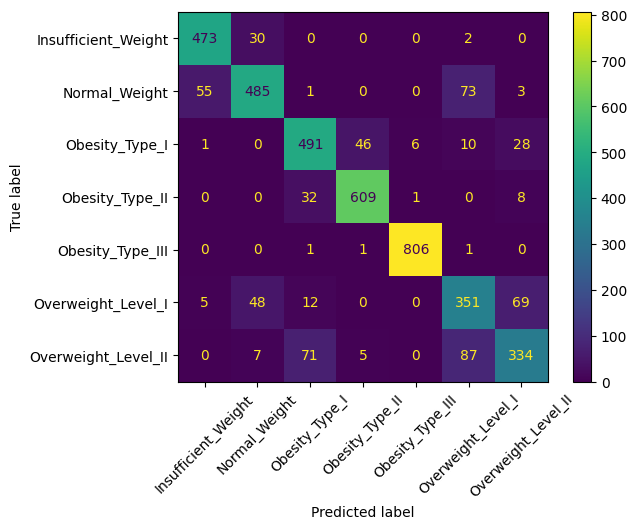

In [18]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8555)

# Fit model
svm_model.fit(X_train, y_train)

# Prediction on test 
y_pred = svm_model.predict(X_test)

# Conf matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_model.named_steps['classifier'].classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.named_steps['classifier'].classes_)
disp.plot(xticks_rotation=45)

print(classification_report(y_test, y_pred))

Applying to Test Data

In [19]:

X_final_test = TEST[['Gender','Age','Height','Weight','family_history_with_overweight']]
y_test_pred = svm_model.predict(X_final_test)

TEST['NObeyesdad'] = y_test_pred

first_col_name = TEST.columns[0]

output_df = TEST[[first_col_name, 'NObeyesdad']]

print(output_df.head())

# Save to CSV line commented out
#output_df.to_csv('svm_predictions.csv', index=False)

      id          NObeyesdad
0  20758     Obesity_Type_II
1  20759  Overweight_Level_I
2  20760    Obesity_Type_III
3  20761     Obesity_Type_II
4  20762    Obesity_Type_III


SVM Assumption:

Data is Independent: Passed no indication that one observation effects another.

Data is identically distributed: Passed. KS test pvalue large therefore fail to reject null that samples are drawn from same distributions. i.e distributions don't differ.

In [20]:

# Kolmogorov smirnov test

# Compare distributions between two splits
split1_idx, split2_idx = list(cv.split(X, y))[:2]
stat, p = ks_2samp(X.iloc[split1_idx[1]]['Age'], X.iloc[split2_idx[1]]['Age'])
print(f'KS test p-value: {p:.4f}')


KS test p-value: 0.6881


All models above are trained on 80% of 20,758. Then the classification report uses the remaining test set to generate metrics. This is why you see supports of 4152. Also given the imbalance of classes it is best to refer to weighted averages for the precision, recall, and f1-score.

In [21]:
TRAIN.shape

(20758, 18)